# Simple diffusion model(Denoising Diffusion Probabilistic Models)

From paper https://arxiv.org/pdf/2006.11239.pdf

Diffusion models are powerful generative models(can be applied to different types of data, this example focuses on images) able to generate high quality and diverse images, they are also compute intensive and generation time is slower than other types of models(that's why this example has not high quality images, this was created in a personal computer with small GPU with a small number of epochs and diffusion steps). Diffusion models are inspired by [non-equilibrium statistical physics](https://arxiv.org/pdf/1503.03585.pdf).
 Some famous large diffusion models are:
* GLIDE
* Dall-E(2)
* Imagen
* Stable Diffusion

<center>
<img src="./imgs/blog-stable-diffusion-_prateca-u-tekstu_gif.gif">

Img src:[Prog. World](https://prog.world/sherudim-under-the-hood-of-stable-diffusion/)
</center>

Diffusion models generate data starting from noise and gradually denoising(removing the noise) one step at a time until the final image is obtained, this is known as reverse diffusion(in the following image right to left). Forward diffusion occurs at training time and implies the inverse: start from the final image and gradually add noise to it until pure noise is obtained(in the following image left to right).

<center><img src="https://www.vegait.co.uk/media/lqdjatqq/blog-stable-diffusion_prateca-u-tekstu-4.jpg?width=751&height=299&mode=max">

Img src: [Nvidia developer blog](https://developer.nvidia.com/blog/improving-diffusion-models-as-an-alternative-to-gans-part-2/)</center>

Internally a neural network is trained to predict the noise so it can be subtracted in order to reverse the noising process. In the following image we have a noisy image, the neural network predicts the noise and then a portion(epsilon) of it is subtracted from the image to obtain a less noisy image, this process is repeated multiple steps to gradually remove noise.

<center><img src="https://www.vegait.co.uk/media/qrof0p31/blog-stable-diffusion_prateca-u-tekstu-6.jpg?width=736&height=293&mode=max">

Img src: [Nvidia developer blog](https://developer.nvidia.com/blog/improving-diffusion-models-as-an-alternative-to-gans-part-2/)
</center>

This notebook implements a simple and small diffusion model from the paper (Denoising Diffusion Probabilistic Models) described next:

## Forward difussion

Forward gradually converts an image to noise. Formally the forward diffusion process is a markov chain of T states(every step depends only in the previous step), the distribution $q(x_t|x_{t-1})$ (gaussian)of a variable $x$ in time "$t$" depends only(conditioned on) in the variable $x$ at time "t-1" $x_{t-1}$ (the variables $x$ are intermediate noisy images), at each step of the chain gaussian noise with variance $\beta_{t}$ is added to the last variable at time $t-1$. There are multiple ways of defining the variances $\beta$, in the literature these are called "schedules", in this notebook linear schedule is used.

<center>
<img src="./imgs/forward_diffusion.png">

img source: [theaisummer](https://theaisummer.com/diffusion-models/)
</center>

A remarkable property is that with some algebra and probability theory(reparametrization trick)the markov chain(forward diffusion) can be manipulated to obtain the gaussian distrubution at time $t$ $q(x_t|x_0)$ only from the original image $x_0$, this allows equivalent direct sampling in one single step. If we remember the $x_t$ in the markov chain are intermediate images, this means we can generate intermediate noisy images only from the initial image $x_0$ and the variance schedule.
We introduce the variables $
\alpha_t$ and get:

<center>
<img src="./imgs/alphat.png">
</center>

<center>
<img src="./imgs/alphabart.png">
</center>
<center>
<img src="./imgs/equivalent_diffusion.png"></center>

In the paper it is shown that with a large enough $T$ (number of diffusion steps) and a well defined variance schedule, the last noisy image is a sample from a standard gaussian distribution with mean 0 and variance 1, this allows to then use a standard gaussian as starting point of the generation(reverse diffusion).

## Reverse Diffusion

Reverse diffusion gradually converts pure gaussian noise to a final image using the reverse markov chain $q(x_{t-1}|x_{t})$(the papers shows that the variances beta from the schedule should be small for this to be gaussian). 
<center><img src="./imgs/backward_diffusion.png"></center>

Contrary to the forward markov chain, the distribution in the backward markov chain cannot be analytically calculated, so it is needed to find an approximation, and that's where a neural network comes into play, it will be used to learn a distribution(with parameters $\theta$) $p_\theta(x_{t-1}|x_t)$ that approximates $q(x_{t-1}|x_t)$. Since $q$ is gaussian  what the neural network has to learn is the mean and variance of the distribution as a function of $x_t$. In this example the variance is fixed(via  the schedule) instead of learned, and the paper shows that the mean can be defined in terms of the alphas $\alpha$ and an approximation of the noise $\epsilon(x_t)$. So in summary the neural nettwork has to learn to predict the noise from a given image $x_t$ and a portion of it(weighted in terms of the variances) is calculated and then this is subtracted from the image $x_t$, this  gives us the following expression for the mean of the gaussian:

<center><img src="./imgs/diffusion_mean.png"></center>

## Loss Function and Training

The training procedure is similar to the procedure used by autoencoders by optimizing the usual variational evidence lower bound (ELBO) on the negative log likelihood with the KL-divergence between the markov chain real q and predicted q gaussian distributions. 
<center>
<img src="./imgs/diffusion_ELBO.png">

<img src="./imgs/diffusion_KL.png">
</center>

More details can be found in the paper but it shows that training is equivalent to minimizing the l2 distance between real gaussian noise and predicted noise(this is what will  go into the code) for a step t:

<center><img src="./imgs/diffusion_l2_distance.png"></center>

## Algorithms

This theory allows us to define 2 simple and short algorithms, one for training and one for sampling generated images.

### Algorithm 1(Training)

<center><img src="./imgs/diffusion_algorithm1.png"></center>

In simple words:
1. Pick a random image from the dataset
2. Sample a random t(step number) from 1 to T with equal probability.
3. Generate random noise epsilon
4. Use the noise approximator(neural network) to predict the noise of an intermediate image at timestep t
5. Calculate the loss(MSE) between the real noise(step 3) and predicted noise(step 4)
6. Calculate gradient of the loss with respect to the neural network parameters and perform gradient descent step
7. Go  to step 1 until convergence(or a fixed number of iterations)


### Algorithm 2(Sampling)
This implements the backward diffusion, a neural network(U-net in this example) is used to predict the noise, alphas(from the variances) calculated during training are used.

<center><img src="./imgs/diffusion_sampling.png"></center>


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, Tuple
from tqdm import tqdm

In [2]:
NUM_PLOT_PICTURES = 5
DEVICE = "cuda:0"
#DEVICE = "cpu"


BATCH_SIZE = 512
EPOCHS = 40

In [3]:
device = torch.device(DEVICE)

In [4]:
# normalize subtracting the mean 0.5 and dividing by the standard deviawtion 0.5
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

In [5]:
train_set = torchvision.datasets.MNIST(root="./diffusion_data",train=True,download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,batch_size = BATCH_SIZE, shuffle= True)

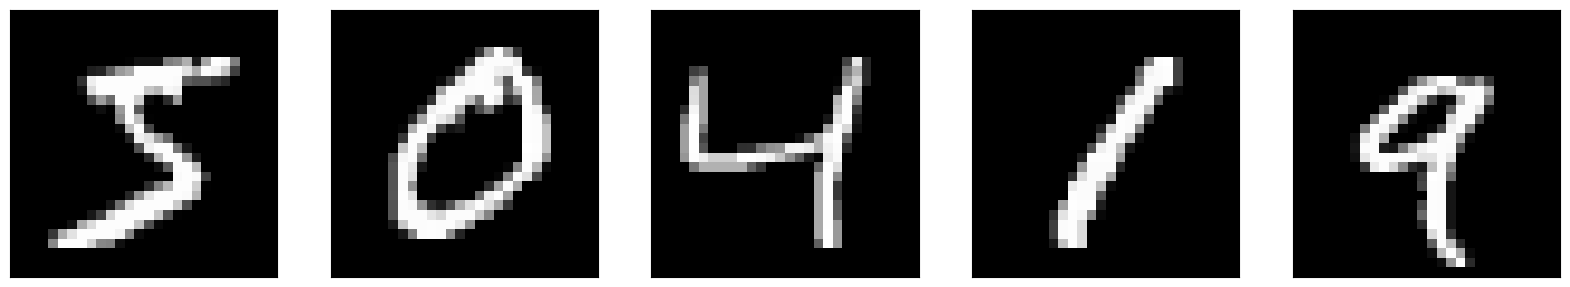

In [6]:
plt.figure(figsize=(20,5))

for i in range(NUM_PLOT_PICTURES):
    img = train_set[i][0]
    ax = plt.subplot(1,NUM_PLOT_PICTURES,i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.imshow(img.cpu().squeeze().numpy(), cmap="gist_gray")
plt.show()

In [7]:

IMAGES_CHANNELS = 1
IMAGES_SIZE = 28

def plot_sample(model):
    with torch.no_grad():
        figure = plt.figure(figsize=(10,10))

        for i in range(NUM_PLOT_PICTURES):
            sample = model.forward_diffusion((IMAGES_CHANNELS, IMAGES_SIZE, IMAGES_SIZE)).cpu()
            plt.subplot(1, NUM_PLOT_PICTURES, i+1)
            plt.imshow(sample.reshape(IMAGES_SIZE,IMAGES_SIZE),cmap="gray")
            plt.axis("off")
    plt.show()


## Create the variance schedule and calculate all dependant variables

In [8]:

def ddpm_schedule(beta1, beta2, T):
    """create the schedule for the betas(variances) lineraly
       in the paper: variance increases with timesteps
    """
    beta_t = torch.linspace(beta1,beta2,T,dtype=torch.float32) # the variance schedule for the markov chain
    beta_t = (beta2-beta1) * torch.arange(0,T+1,dtype=torch.float32)/T+beta1

    # calculate derived quantities from beta
    alpha_t = 1 - beta_t # from equation 2 αt:= 1 − βt
    sqrt_beta_t  =torch.sqrt(beta_t) # step 4 of algorithm2 σt
    ## work in logarithmic space for stability but transform back using exp()(product becomes sum)
    log_alpha_t = torch.log(alpha_t)
    log_alpha_bar_t = torch.cumsum(log_alpha_t,dim=0)
    alpha_bar_t = torch.exp(log_alpha_bar_t) # α¯t:= cumprod(αt),

    sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t) # used for the mean of the gaussian in the conditional distribution(aquation 4) for xt conditioned on x0
    one_over_sqrt_alpha_t = 1/torch.sqrt(alpha_t) # from equation 10 and step 4 of algorithm 2
    one_minus_alpha_bar_t  = 1 - alpha_bar_t # used for the var of the gaussian in the conditional distribution(equation 4)
    one_over_sqrt_alpha_bar_t = 1/torch.sqrt(alpha_bar_t) # from equation 9 of the paper
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t) # from equation 9 of the paper
    one_minus_alpha_t_over_sqrt_omab = (1 - alpha_t)/sqrt_one_minus_alpha_bar_t # from step 4, algorithm 2(sampling)

    return {
        "beta_t": beta_t,
        "alpha_t": alpha_t,
        "sqrt_beta_t": sqrt_beta_t,
        "log_alpha_t": log_alpha_t,
        "log_alpha_bar_t": log_alpha_bar_t,
        "alpha_bar_t": alpha_bar_t,
        "sqrt_alpha_bar_t": sqrt_alpha_bar_t,
        "one_over_sqrt_alpha_t": one_over_sqrt_alpha_t,
        "one_minus_alpha_bar_t": one_minus_alpha_bar_t,
        "one_over_sqrt_alpha_bar_t": one_over_sqrt_alpha_bar_t,
        "sqrt_one_minus_alpha_bar_t": sqrt_one_minus_alpha_bar_t,
        "one_minus_alpha_t_over_sqrt_omab": one_minus_alpha_t_over_sqrt_omab
    }

ddpm_schedule(1e-4,0.02,1000)

{'beta_t': tensor([1.0000e-04, 1.1990e-04, 1.3980e-04,  ..., 1.9960e-02, 1.9980e-02,
         2.0000e-02]),
 'alpha_t': tensor([0.9999, 0.9999, 0.9999,  ..., 0.9800, 0.9800, 0.9800]),
 'sqrt_beta_t': tensor([0.0100, 0.0109, 0.0118,  ..., 0.1413, 0.1414, 0.1414]),
 'log_alpha_t': tensor([-0.0001, -0.0001, -0.0001,  ..., -0.0202, -0.0202, -0.0202]),
 'log_alpha_bar_t': tensor([-1.0002e-04, -2.1995e-04, -3.5974e-04,  ..., -1.0087e+01,
         -1.0108e+01, -1.0128e+01]),
 'alpha_bar_t': tensor([9.9990e-01, 9.9978e-01, 9.9964e-01,  ..., 4.1599e-05, 4.0767e-05,
         3.9952e-05]),
 'sqrt_alpha_bar_t': tensor([0.9999, 0.9999, 0.9998,  ..., 0.0064, 0.0064, 0.0063]),
 'one_over_sqrt_alpha_t': tensor([1.0001, 1.0001, 1.0001,  ..., 1.0101, 1.0101, 1.0102]),
 'one_minus_alpha_bar_t': tensor([1.0002e-04, 2.1994e-04, 3.5965e-04,  ..., 9.9996e-01, 9.9996e-01,
         9.9996e-01]),
 'one_over_sqrt_alpha_bar_t': tensor([  1.0001,   1.0001,   1.0002,  ..., 155.0461, 156.6187, 158.2087]),
 'sqrt_one

## Model architecture

### Noise predictor model
This is a simplified U-net, the papers used a much more complex and bigger models

In [9]:
def model_block(input_channels,output_channels):
    """Will be used to create the conv2d UNET
       this one is simplified, the paper uses skip-connections among others
    """
    return nn.Sequential(
        nn.Conv2d(input_channels,output_channels,7,padding=3),
        nn.BatchNorm2d(output_channels),
        nn.LeakyReLU()
    )

In [10]:
class SimpleUNet(nn.Module):
    """The unet for the diffusion model"""
    def __init__(self,num_channels):
        super(SimpleUNet,self).__init__()
        self.network = nn.Sequential(
            model_block(num_channels,64),
            model_block(64,128),
            model_block(128,256),
            model_block(256,512),
            model_block(512,256),
            model_block(256,128),
            model_block(128,64),
            nn.Conv2d(64, num_channels,3,padding=1)
        )

    def forward(self,x,t):
        return self.network(x)

### Diffusion model

This used both the scheduler and the U-net predictor model to create a complete diffusion model.

In [11]:
class DDPM(nn.Module):
    """the denoising diffusion probabilistic model"""
    def __init__(self,epsilon_theta,beta1,beta2,n_T):
        super(DDPM,self).__init__()
        self.epsilon_theta = epsilon_theta # the noise predictor model parametrized by theta(step 5 of altorighm 1), this is to be trained
        self.n_T = n_T

        # using buffers allows to access every item in the dictionary by name with dot operator for the class
        ## for example self.key and let pytorch perform device placement
        ## plus, these objects are not considered parameters(do not require gradients)
        for key,value in ddpm_schedule(beta1=beta1,beta2=beta2,T=n_T).items():
            self.register_buffer(key,value)

    def forward(self, x):
        # algorithm 1(training) from paper
        ## the x0 from the paper(step1 of algorithm 1) are the x batch
        t = torch.randint(0,self.n_T,(x.shape[0],)).to(device) #sample timestep(line 3 of algorithm 1), minibatch of the same size of images
        epsilon = torch.randn_like(x) # sample gaussian noise with same dimensions as the batch x(step 4 of algorithm 1)

        # the following samples a x at timestep t for every image in the batch x
        ## this will be used to predict the noise of the image x_t
        ## this is based on equation 4 and step 5 of algorithm 1(argument of epsilon theta)
        ## this is an intermediary image for the diffusion process
        x_t = (self.sqrt_alpha_bar_t[t,None,None,None]*x + self.sqrt_one_minus_alpha_bar_t[t,None,None,None]*epsilon)  
        
        #  return the real noise and the noise prediction
        return epsilon, self.epsilon_theta(x_t,t/self.n_T)
    
    def forward_diffusion(self,size):
        # algorithm 2(sampling) from paper
        x_t = torch.randn(1,*size).to(device) # start generation from random noise

        for t in range(self.n_T,0,-1):
            # step 3 of altorighm 2
            if t > 1:
                z = torch.randn(1,*size).to(device)
            else:
                z = 0
            # step 4 of algorithm 2
            x_t = (
                self.one_over_sqrt_alpha_t[t]*(x_t-self.one_minus_alpha_t_over_sqrt_omab[t]*self.epsilon_theta(x_t,t/self.n_T)) + 
                self.sqrt_beta_t[t]*z
            )

        return x_t

In [12]:
diffusion_model = DDPM(epsilon_theta=SimpleUNet(1), #one input channel, this is the trainable model
                       beta1=1e-4,#initial variance
                       beta2=0.02, # final variance,
                       n_T=1000 #number of  diffusion steps
                       ).to(device)

In [13]:
optimizer = torch.optim.Adam(diffusion_model.parameters(),lr=2e-4)
loss = nn.MSELoss()

Starting training:


epoch:1 step 1, loss:1.16509
epoch:1 step 51, loss:0.33044
epoch:1 step 101, loss:0.21231


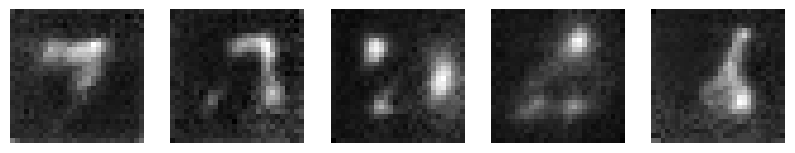

epoch:2 step 1, loss:0.07547
epoch:2 step 51, loss:0.07456
epoch:2 step 101, loss:0.07146


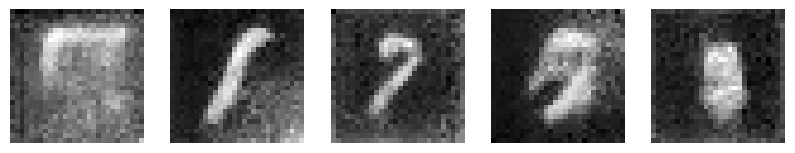

epoch:3 step 1, loss:0.06536
epoch:3 step 51, loss:0.06033
epoch:3 step 101, loss:0.05922


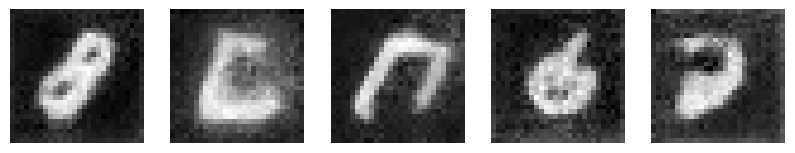

epoch:4 step 1, loss:0.05732
epoch:4 step 51, loss:0.05485
epoch:4 step 101, loss:0.05356


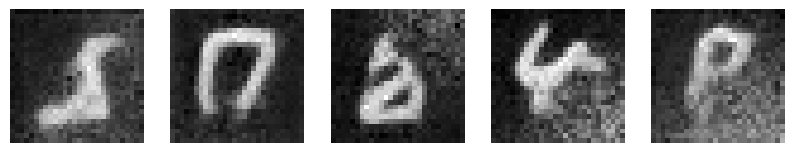

epoch:5 step 1, loss:0.05571
epoch:5 step 51, loss:0.04915
epoch:5 step 101, loss:0.04845


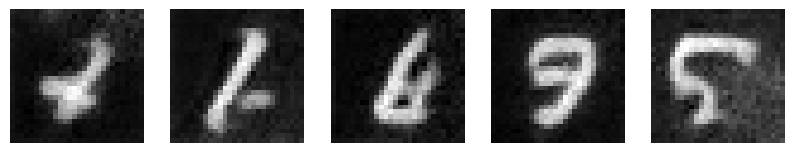

epoch:6 step 1, loss:0.04989
epoch:6 step 51, loss:0.04701
epoch:6 step 101, loss:0.04639


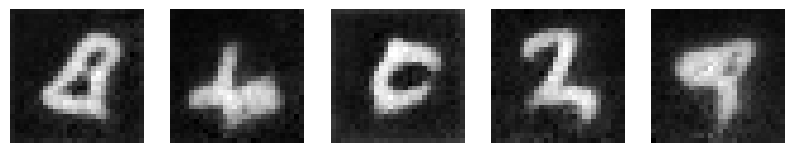

epoch:7 step 1, loss:0.04902
epoch:7 step 51, loss:0.04376
epoch:7 step 101, loss:0.04415


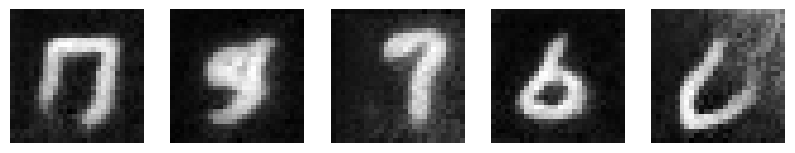

epoch:8 step 1, loss:0.04370
epoch:8 step 51, loss:0.04312
epoch:8 step 101, loss:0.04267


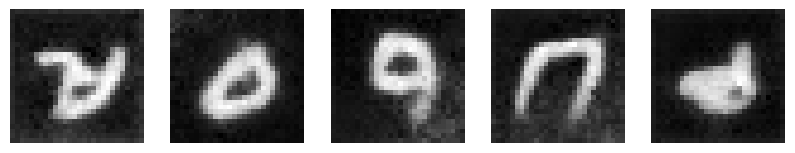

epoch:9 step 1, loss:0.03988
epoch:9 step 51, loss:0.04176
epoch:9 step 101, loss:0.04117


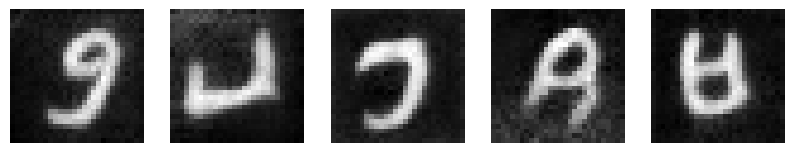

epoch:10 step 1, loss:0.04129
epoch:10 step 51, loss:0.03954
epoch:10 step 101, loss:0.03956


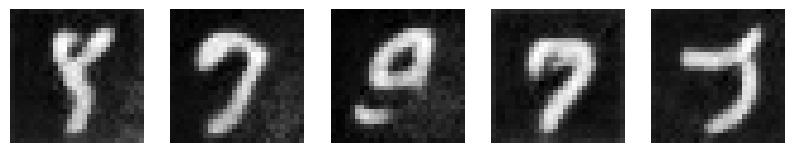

epoch:11 step 1, loss:0.04126
epoch:11 step 51, loss:0.03901
epoch:11 step 101, loss:0.03903


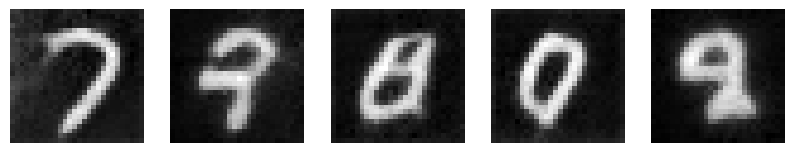

epoch:12 step 1, loss:0.03960
epoch:12 step 51, loss:0.03829
epoch:12 step 101, loss:0.03779


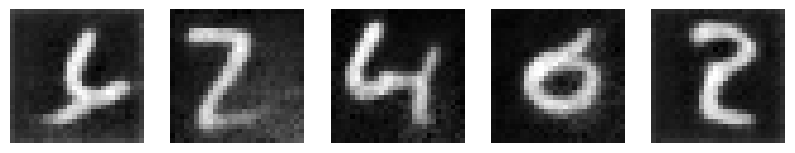

epoch:13 step 1, loss:0.03998
epoch:13 step 51, loss:0.03740
epoch:13 step 101, loss:0.03739


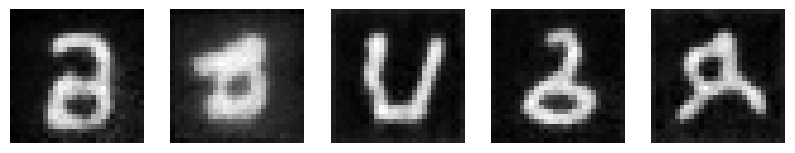

epoch:14 step 1, loss:0.03612
epoch:14 step 51, loss:0.03694
epoch:14 step 101, loss:0.03687


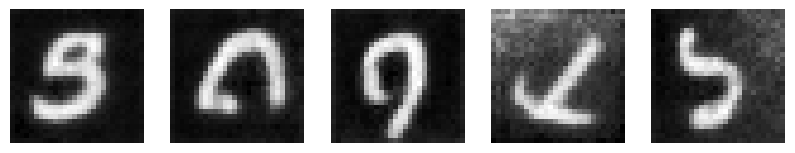

epoch:15 step 1, loss:0.03587
epoch:15 step 51, loss:0.03593
epoch:15 step 101, loss:0.03572


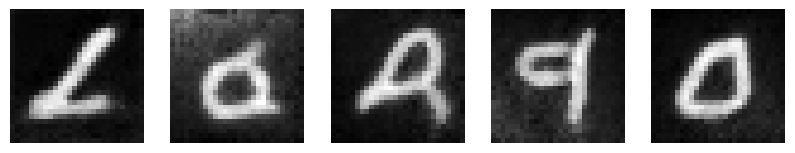

epoch:16 step 1, loss:0.03756
epoch:16 step 51, loss:0.03622
epoch:16 step 101, loss:0.03573


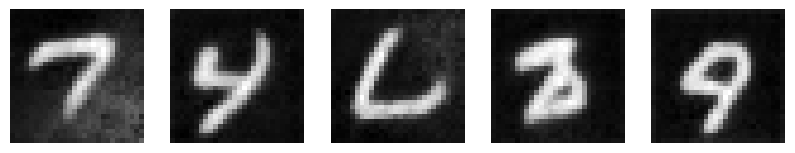

epoch:17 step 1, loss:0.03687
epoch:17 step 51, loss:0.03537
epoch:17 step 101, loss:0.03511


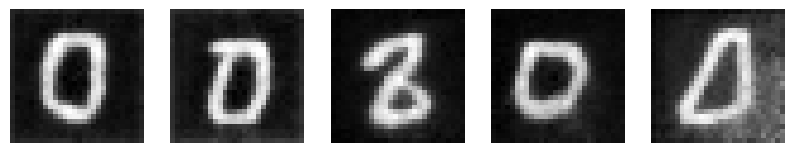

epoch:18 step 1, loss:0.03354
epoch:18 step 51, loss:0.03448
epoch:18 step 101, loss:0.03461


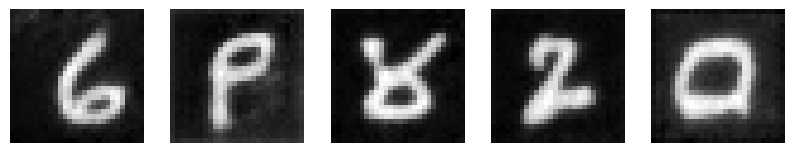

epoch:19 step 1, loss:0.03316
epoch:19 step 51, loss:0.03349
epoch:19 step 101, loss:0.03389


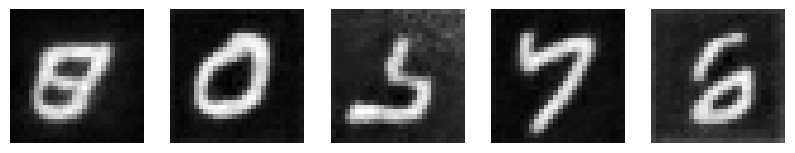

epoch:20 step 1, loss:0.03641
epoch:20 step 51, loss:0.03406


In [14]:
print("Starting training:")

for epoch in range(EPOCHS):
    diffusion_model.train()
    
    running_loss = 0.0

    for step, data  in enumerate(train_loader):
        X,Y = data
        X = X.to(device)

        # train step
        optimizer.zero_grad()
        # forward diffusion of the DDPM model
        ## first get the  sample noise epsilon, and predicted  noise epsilon theta
        epsilon, epsilon_theta = diffusion_model(X) 
        ## get the loss from real and predicted noise
        step_loss = loss(epsilon,epsilon_theta)
        ## get gradients with backpropagation and perform gradient descent step
        step_loss.backward()
        optimizer.step()

        running_loss += step_loss.item()
        #print(running_loss)
        #progress_bar.set_description(f"epoch:{epoch}, loss:{running_loss/(step+1):.5f}")

        if step % 50 == 0:
            print(f"epoch:{epoch+1} step {step+1}, loss:{running_loss/(step+1):.5f}")
    #if epoch % 5 == 0:
    plot_sample(diffusion_model)